In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from keras.callbacks import TensorBoard
from tf_explain.callbacks.grad_cam import GradCAMCallback
from keras.optimizers import Adam, SGD, Nadam

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.models import load_model
from tensorflow.keras import models, layers
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import Image, display
from tf_explain.callbacks.grad_cam import GradCAMCallback

from utils.utils import get_img_array, make_gradcam_heatmap, save_and_display_gradcam

In [2]:
CNN_BASIC_TWO_CONV = load_model('../models/BASIC_CONV')
CNN_BASIC_THREE_CONV = load_model('../models/BASIC_CONV_3')
CNN_DILATED = load_model('../models/DILATED')
CNN_DILATED_NADAM = load_model('../models/DILATED_NADAM')
CNN_INCEPTION = load_model('../models/INCEPTION_MODULE')
CNN_INCEPTION_NADAM = load_model('../models/INCEPTION_MODULE_NADAM')
CNN_ALEXNET = load_model('../models/ALEXNET_MODEL')
CNN_ALEXNET_NADAM = load_model('../models/ALEXNET_MODEL_NADAM')
INCEPTION_RESNET = load_model('../models/INCEPTION_RESNET')
VGG19 = load_model('../models/VGG19')

In [3]:
data_dir = '..\dataset'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="training",
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

val_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="validation",
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

test_images = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(64, 64),
    batch_size=1,
    class_mode='binary')

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
model_builder = keras.applications.xception.Xception
img_size = (32, 32)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [11]:
model = load_model('../models/DILATED_NADAM')

In [12]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, None, None, 32)    0         
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, None, None, 64)   

In [ ]:
correct = 0
for i in range(len(test_images)):
    label = int(test_images[i][1][0])
    img_array = test_images[i][0]
    res = model.predict(img_array)[0][0]
    correct+=int(int(res>.5)==int(label))

In [13]:
model.layers[-1].activation = None

In [9]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    #img = keras.utils.load_img(img_path)
    img = img[0]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)
    
    return superimposed_img

1/1 [==============================] - 0s 21ms/step


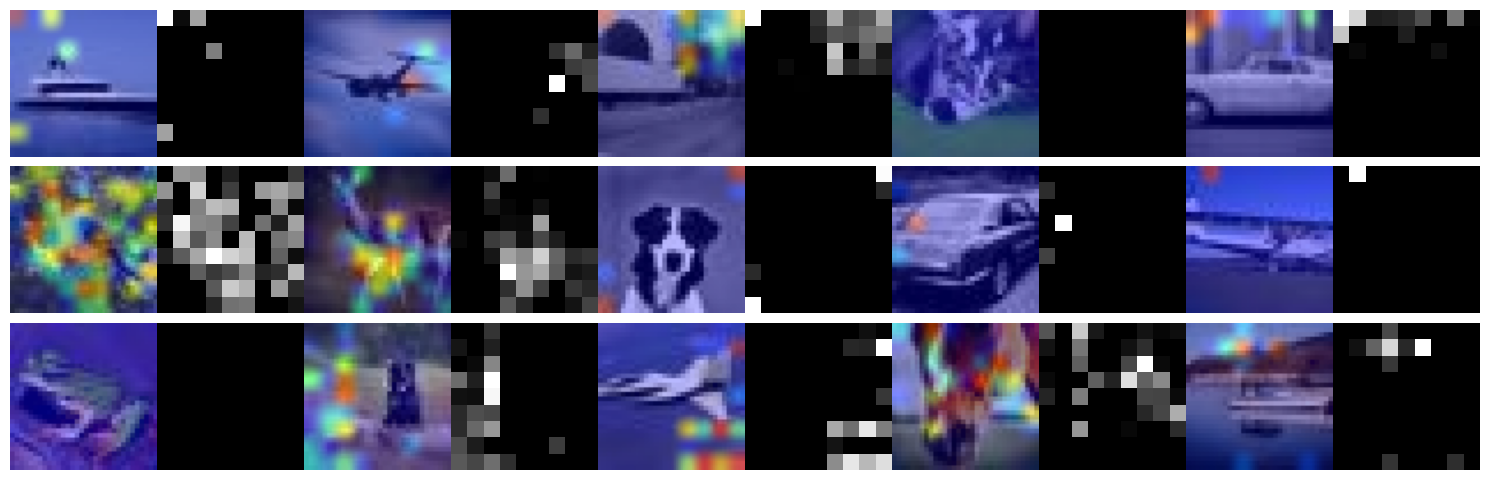

In [25]:
last_conv_layer_name = "conv2d_14"
count = 0
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(len(test_images)):
    label = int(test_images[i][1][0])
    img_array = test_images[i][0]
    pre = CNN_DILATED_NADAM.predict(img_array)
    if label == 0 and int(pre>.5) == 0:
        if count == 15:
            break
        
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        col = count%5
        imcol = col*2
        row = count//5
        
        si_image = save_and_display_gradcam(img_array, heatmap, cam_path=f"../feature_track/image_{i}.jpg", alpha=0.003)
        axes[row][imcol].imshow(si_image) 
        axes[row][imcol].axis('off') 
        axes[row][imcol+1].imshow(heatmap, cmap='gray') 
        axes[row][imcol+1].axis('off') 
        count+=1
        
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
        

1/1 [==============================] - 0s 20ms/step


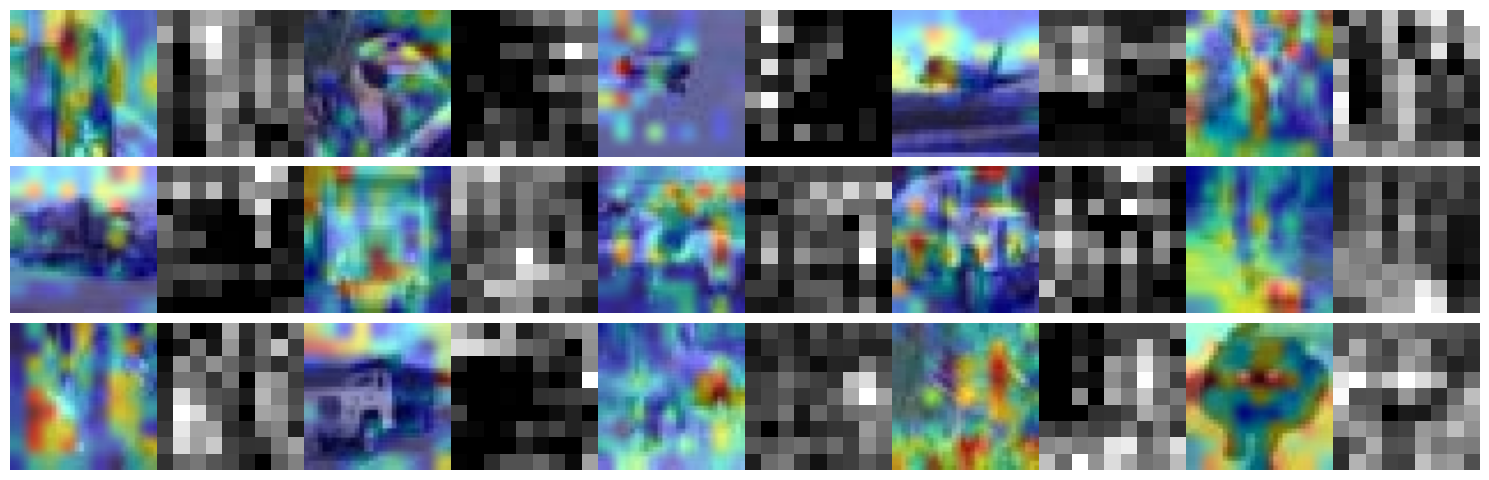

In [26]:
last_conv_layer_name = "conv2d_14"
count = 0
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(len(test_images)):
    label = int(test_images[i][1][0])
    img_array = test_images[i][0]
    pre = CNN_DILATED_NADAM.predict(img_array)
    if label == 1 and int(pre>.5) == 1:
        if count == 15:
            break
        
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        col = count%5
        imcol = col*2
        row = count//5
        
        si_image = save_and_display_gradcam(img_array, heatmap, cam_path=f"../feature_track/image_{i}.jpg", alpha=0.003)
        axes[row][imcol].imshow(si_image) 
        axes[row][imcol].axis('off') 
        axes[row][imcol+1].imshow(heatmap, cmap='gray') 
        axes[row][imcol+1].axis('off') 
        count+=1
        
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
        